# 0. Utils

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import re
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d
import scipy.linalg as la
import os
from scipy.stats import mode
from scipy import stats
import statsmodels.formula.api as smf
import time
import collections as c

def to_num(s):
    try:
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            return s

# check if it is integer
def is_int(x):
    """
    """
    
    try:
        return x-int(x) == 0
    except:
        return np.array(list(map(int, x)))-x==0

# 1. Load raw data (`data`)

In [2]:
RES = []
print('----start loading----')
for month in ['march', 'april', 'may']:
    file_parts = len(os.listdir(path= '../data/' + month))-1
    for i in range(file_parts):
        fname = '../data/' + month + '/part-' + str(i).rjust(5, '0')
        print('{}: {:.2f}'.format(month, i/file_parts*100), end='%\r')
        with open(fname, 'r') as lines:
            count = 0
            ind_status, ind_pose = False, False
        #     numRows = 0
            for line in lines:
                tmp = line.split()
        #         print(line.split())
                if(tmp[1] == 'aw_idl/VehicleInput'):
                    res = []
                    res.extend(list(map(to_num, tmp)))
                    count += 1
        #             RES.append(res)
                elif(tmp[1] == 'aw_idl/VehicleStatus'):
                    tmp_status = list(map(to_num, tmp))
                    ind_status = True
                elif(count == 1):
                    tmp_pose = list(map(to_num, tmp))
                    ind_pose = True
                    count = 0
                if ind_status and ind_pose:
                    res.extend(tmp_pose)
                    res.extend(tmp_status)
                    RES.append(res)
                    ind_status, ind_pose = False, False
    print(month, end =' done.               \n')
print('----finish loading----')

----start loading----
march done.               
april done.               
may done.               
----finish loading----


In [3]:
cols = ['bag_name', 'topic', 'time', 'input_status', 'cmd', 'steering_input', 'bag_name2', 'topic2', 'time2', 'v', 'acc', 'x', 'y', 'z', 'pitch', 'omega_yaw', 'bag_name3', 'topic3', 'time3', 'system_status', 'speed_status', 'steering_status']
data = pd.DataFrame(RES, columns = cols)
data = data.drop(['topic', 'topic2', 'topic3', 'time2', 'time3', 'bag_name2', 'bag_name3'], axis=1)
data = data.sort_values(by = 'time')
data = data.reset_index(drop=True)

# 2. Data preprocess

In [6]:
bag_name = data.bag_name
acc = data.acc
v = data.v
input_status = data.input_status
cmd = data.cmd
x = data.x
y = data.y
z = data.z
pitch = np.sin(data.pitch)
pitch2 = pitch/abs(pitch).max()
status = data.system_status
ts = data.time # timestamp
v_diff = v.diff() * 10
steering_status = data.steering_status
omega_yaw = data.omega_yaw
# t = np.array(list(map(lambda x:time.strftime('%Y%m%d%H%M%S', time.localtime(x)), ts)))
# dayofyear = np.array(list(map(lambda x:to_num(time.strftime('%j', time.localtime(x))), ts)))
# month = np.array(list(map(lambda x:to_num(time.strftime('%m', time.localtime(x))), ts)))
# week = np.array(list(map(lambda x:to_num(time.strftime('%W', time.localtime(x))), ts)))

In [8]:
tmp = []
time_delay = 3
th_acc = 0.25
th_length = 50
th_v_l = 1.3
th_v_u = 1.6
n = len(data)
in_sample = False
sample_grp = 0
# cmd[i] ~ v[i+time_delay] ~ acc[i+time_delay]
for i in range(n-time_delay):
    # should this frame be in sample?
    sample_ind = ((v[i+time_delay]>th_v_l) and (v[i+time_delay]<th_v_u) and 
                  (acc[i+time_delay]!=0) and (abs(v_diff[i+time_delay])<th_acc) and
                  (status[i] == 1) and (cmd[i]>20) and (cmd[i]<30) and (abs(steering_status[i])<300))
    if not in_sample:
        if sample_ind:
            in_sample = True # whether is the state of steady motion
            start_ = i + time_delay
    else:
        if sample_ind:
            pass
        else:
            end_ = i + time_delay # exclusive [start_, end_), index of v and acc ~ cmd[i+time_delay]
            in_sample = False
            if((end_ - start_) > th_length) and (bag_name[start_-time_delay] == bag_name[end_]):
                tmp.append([sample_grp, (start_, end_)])
                sample_grp += 1
    if i % 10000 == 0:
        print('Progressing: {:.2f} %'.format(i/n*100), end='\r')

In [9]:
df = []
for i in range(len(tmp)):
    idx = np.arange(*tmp[i][1])
    sample_grp = tmp[i][0]
    for idx_ in idx:
        df.append([bag_name[idx_-time_delay], ts[idx_-time_delay], v[idx_], cmd[idx_-time_delay], acc[idx_],
                         v_diff[idx_], pitch[idx_], status[idx_-time_delay], omega_yaw[idx_],
                         steering_status[idx_-time_delay], sample_grp])
    print('Progressing: {:.2f} %'.format(i/len(tmp)*100), end='\r')

In [10]:
data2 = pd.DataFrame(df, columns = ['bag_name', 'timestamp', 'v', 'cmd', 'acc', 'v_diff', 'pitch' , 'status', 'omega_yaw', 'steering_status', 'sample_grp'])

In [11]:
n2 = len(data2)
n_batch = 100
batch_size = n2 // n_batch + 1
grp = data2.index.values // n_batch

In [12]:
c.Counter(data2.bag_name)

Counter({'2019_03_01_19_26_28_arts16_2': 2544,
         '2019_03_02_19_33_07_arts16_2': 2283,
         '2019_03_04_19_31_30_arts16_2': 412,
         '2019_03_05_19_54_03_arts16_2': 2450,
         '2019_03_06_19_54_40_arts16_2': 9426,
         '2019_03_07_19_31_07_arts16_2': 3022,
         '2019_03_10_19_29_57_arts16_2': 333,
         '2019_03_11_19_44_00_arts16_2': 15001,
         '2019_03_12_19_28_50_arts16_2': 4521,
         '2019_03_13_19_32_56_arts16_2': 1589,
         '2019_03_14_19_29_18_arts16_2': 5431,
         '2019_03_16_19_29_44_arts16_2': 1252,
         '2019_03_18_19_31_05_arts16_2': 14322,
         '2019_03_19_19_24_43_arts16_2': 1201,
         '2019_03_21_20_33_33_arts16_2': 4843,
         '2019_03_23_19_31_45_arts16_2': 1535,
         '2019_03_24_19_20_17_arts16_2': 1504,
         '2019_03_24_20_47_18_arts16_2': 6179,
         '2019_03_25_20_30_25_arts16_2': 424,
         '2019_03_27_20_03_45_arts16_2': 9009,
         '2019_03_29_19_35_53_arts16_2': 87,
         '2019_0

In [13]:
def plot_scp(i):
    """
    Draw scatterplot for the i-th batch
    """
    plt.plot(data2[batch_size*i:batch_size*(i+1)].cmd, data2[batch_size*i:batch_size*(i+1)].v, '.')
    print('From bag  {}  to bag  {} '.format(data2.bag_name[batch_size*i], data2.bag_name[batch_size*(i+1)]))

From bag  2019_03_01_19_26_28_arts16_2  to bag  2019_03_02_19_33_07_arts16_2 
From bag  2019_04_05_19_37_44_arts16_2  to bag  2019_04_06_19_27_34_arts16_2 
From bag  2019_04_18_16_00_52_arts16_2  to bag  2019_04_18_16_00_52_arts16_2 


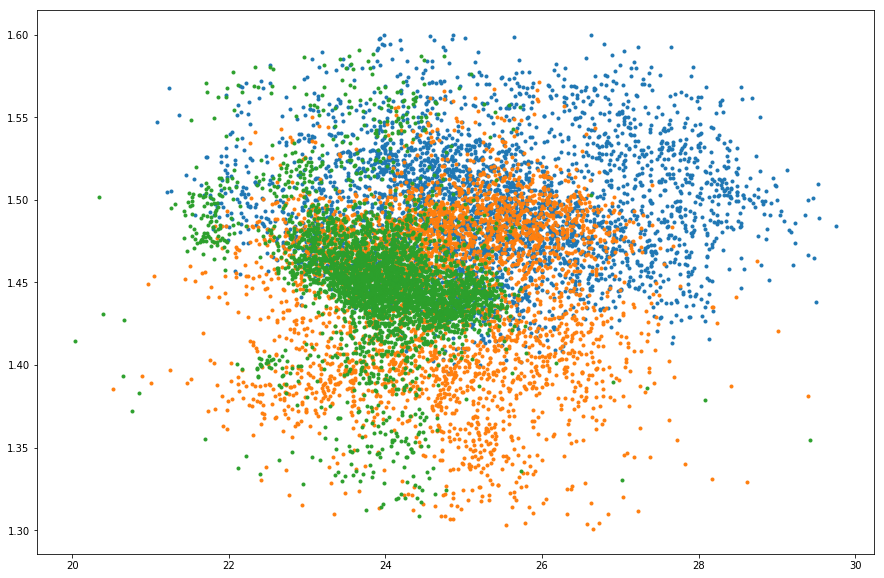

In [14]:
plt.figure(figsize=(15,10))
plot_scp(0)
# plot_scp(1)
# plot_scp(2)
plot_scp(30)
plot_scp(40)
# plot_scp(73)

# Bivariate Normal Model

$$
(v, cmd)^T\sim \mathcal N_t((\mu_v,\mu_{cmd})^T, \Sigma_{v,cmd})
$$

where $t = 0,..., 99$ is the index for equally spaced epoches.

In [15]:
paras = []
for i in range(n_batch):
    d_sub = np.array(data2[int(i*batch_size): int((i+1)*batch_size)][['v', 'cmd']])
    mu = d_sub.mean(axis = 0) # MLE
    Sig = (d_sub - mu).T @ (d_sub - mu) /(len(d_sub)-1) # MLE
    para = (mu, Sig)
    paras.append(para)
mus = np.array(list(map(lambda x: x[0], paras))) # 100 * 2, n_samples * n_d
Sigs = np.array(list(map(lambda x: x[1], paras))) # 100 * 2 * 2, n_samples * n_d * n_d

## Some visualization for estimated parameters

In [16]:
def KL(mu1, mu2, Sig1, Sig2):
    """
    KL divergence of two multivariate normal distribution
    """
    
    return (np.log(la.det(Sig2)/la.det(Sig1))-len(mu1)+np.matrix.trace(la.inv(Sig2)@Sig1)+(mu2-mu1).T@la.inv(Sig2)@(mu2-mu1))

K-L divergence for multivariate normals

$$
KL(p||q) = \frac{1}{2}\left[\log\frac{|\Sigma_2|}{|\Sigma_1|} - d + \text{tr} (\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^T \Sigma_2^{-1}(\mu_2 - \mu_1)\right]
$$

In [17]:
KL_D = np.ones((n_batch, n_batch))
for i in range(KL_D.shape[0]):
    for j in range(KL_D.shape[1]):
        KL_D[i][j] = KL(mus[i], mus[j], Sigs[i], Sigs[j])

+ ## Joint Distribution

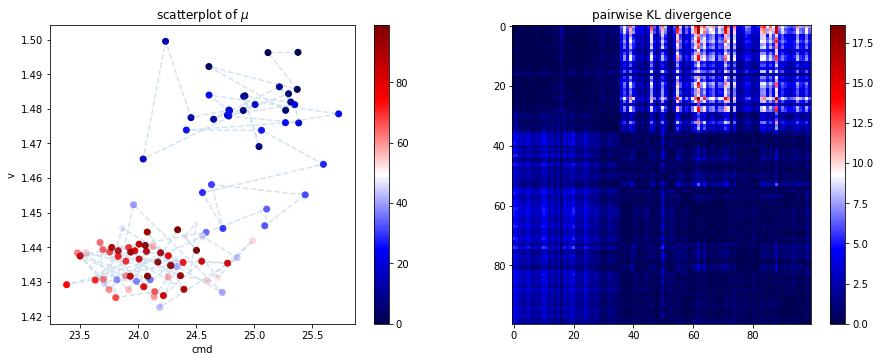

In [18]:
plt.figure(figsize=(15,5.5))
plt.subplot(121)
plt.plot(mus[:,1], mus[:,0], linestyle='--', alpha=0.2)
plt.scatter(mus[:,1], mus[:,0], c=np.arange(0,100), cmap='seismic')
plt.title(r'scatterplot of $\mu$')
plt.xlabel('cmd')
plt.ylabel('v')
plt.colorbar()
plt.subplot(122)
plt.imshow(KL_D, cmap='seismic')
plt.colorbar()
plt.title('pairwise KL divergence')
plt.savefig('p01.png');

+ ## Joint Distribution Parameters

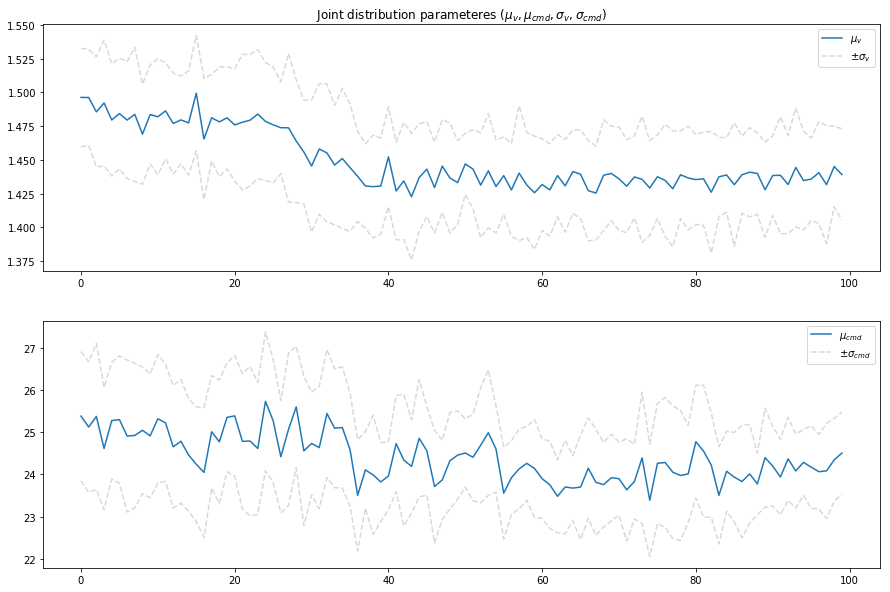

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(mus[:,0], label = r'$\mu_{v}$')
plt.plot(mus[:,0] + np.sqrt(Sigs[:,0,0]), c='gray', linestyle='--', alpha=0.3, label = r'$\pm\sigma_{v}$')
plt.plot(mus[:,0] - np.sqrt(Sigs[:,0,0]), c='gray', linestyle='--', alpha=0.3)
plt.legend()
plt.title(r'Joint distribution parameteres ($\mu_v, \mu_{cmd}, \sigma_{v}, \sigma_{cmd}$)')
plt.subplot(212)
plt.plot(mus[:,1], label = r'$\mu_{cmd}$')
plt.plot(mus[:,1] + np.sqrt(Sigs[:,1,1]), c='gray', linestyle='--', alpha=0.3, label = r'$\pm\sigma_{cmd}$')
plt.plot(mus[:,1] - np.sqrt(Sigs[:,1,1]), c='gray', linestyle='--', alpha=0.3)
plt.legend()
plt.savefig('p02.png');

+ ## Conditional Distribution Parameters, for $P_t(cmd|v=1.45, acc\approx0)$

In [20]:
def cond_dist_para(mu, Sig, cond):
    """
    get parameters for the conditional distribution
    """
    
    res_mu = mu[1] + Sig[1,0]/Sig[0,0]*(cond - mu[0])
    res_sig = Sig[1,1] - Sig[1,0]/Sig[0,0]*Sig[0,1]
    return res_mu, res_sig

In [22]:
paras_cond = []
v_steady = 1.45
for i in range(len(mus)):
    paras_cond.append(cond_dist_para(mus[i], Sigs[i], v_steady))
paras_cond = np.array(paras_cond)

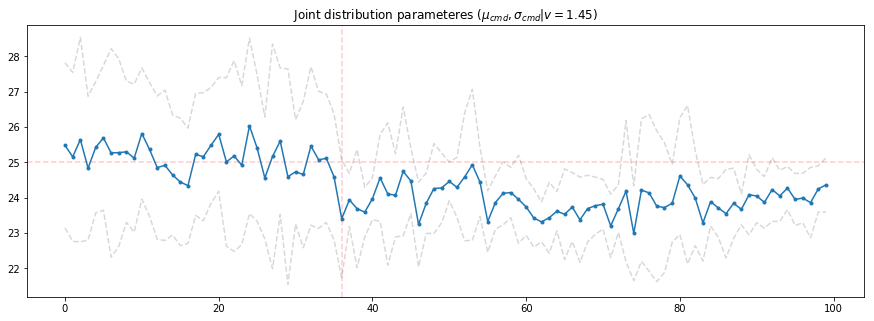

In [23]:
plt.figure(figsize=(15,5))
plt.plot(paras_cond[:,0], marker='.')
plt.title(r'Joint distribution parameteres ($\mu_{cmd}, \sigma_{cmd}|v=1.45$)')
plt.plot(paras_cond[:,0] + paras_cond[:,1], c='gray', linestyle='--', alpha=0.3)
plt.plot(paras_cond[:,0] - paras_cond[:,1], c='gray', linestyle='--', alpha=0.3)
plt.axhline(25, linestyle='--', c='r', alpha=0.2)
plt.axvline(36, linestyle='--', c='r', alpha=0.2)
plt.savefig('p03.png');

+ ## Outlier detection with conditional distribution $P(cmd| v, acc\approx 0)$

Since we have observed that there is something that caused a drift of the distribution at around epoch 36, we would use data from the most recent epochs to construct the conditional distribution and use it to identify possible outliers (confidence interval).

In [24]:
# take the most recent data
data3 = (data2[int(36*batch_size):][['v', 'cmd']])
mu3 = data3.mean(axis=0).values
Sig3 = np.cov(data3.values.T)

In [25]:
def cond_CI(mu, Sig, v_steady = 1.45, alpha=0.05):
    """
    give the 95% confidence interval of cmd given a expected v
    """
    mu_tmp, sig_tmp = cond_dist_para(mu, Sig, v_steady)
    z = stats.norm.ppf(1-alpha/2)
    return (mu_tmp - z*sig_tmp, mu_tmp + z*sig_tmp)

In [26]:
cond_CI(mu3, Sig3, 1.45)

(21.444630710799494, 26.44966382480608)